In [1]:
import numpy as np
import qutip
from CoupledQuantumSystems import DriveTermSymbolic
from CoupledQuantumSystems import DriveTerm, square_pulse_with_rise_fall_envelope
from CoupledQuantumSystems import pulse_shapes_symbo as pss
import matplotlib.pyplot as plt
import scqubits
from CoupledQuantumSystems import TransmonOscillatorSystem
from CoupledQuantumSystems import ODEsolve_and_post_process

# --- Simulation setup from user example --- 
max_ql = 3
max_ol = 10
t_tot = 10 # Made float for linspace
amp_val = 0.4 # Renamed from amp to amp_val to avoid conflict with pss.amp
dt_val = 0.2 # Define dt for the simulation and pulse
num_points = 101
tlist_sim = np.linspace(0, t_tot, num_points)

ncut = 110
tmon_EJ = 20
tmon_EC = 0.25
tmon_ng = 0.3
Er = 15
g = 0.6
kappa_val = 0.03

qbt = scqubits.Transmon(EJ=tmon_EJ, EC=tmon_EC, ng=tmon_ng, ncut=ncut, truncated_dim=max_ql)
osc = scqubits.Oscillator(E_osc=Er, truncated_dim=max_ol, l_osc=1.0)

system = TransmonOscillatorSystem(
    qbt=qbt,
    osc=osc,
    g_strength=g,
    kappa=kappa_val,
    products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol)],
)

if not system.product_to_dressed:
    print("Warning: system.product_to_dressed is empty. Generating default mapping.")
    system.generate_default_mapping()

key_00 = (0,0)
key_01 = (0,1)
key_10 = (1,0)
key_11 = (1,1)

w_d = ((system.evals[system.product_to_dressed[key_01]] - system.evals[system.product_to_dressed[key_00]]) + \
        (system.evals[system.product_to_dressed[key_11]] - system.evals[system.product_to_dressed[key_10]])) / 2

e_ops = [qutip.ket2dm(qutip.basis(max_ql * max_ol, system.product_to_dressed[(ql, ol)])) 
            for ql in range(max_ql) for ol in range(max_ol)] + [system.a.dag() * system.a]


current_t_start = 0.0
current_t_rise = 1e-13 #small number to avoid division by zero
current_t_square = t_tot # Make the square part last for the whole simulation for this test
# current_t_square = 1e9 # User's original very long pulse (basically always on, but it doesn't matter because the total duration is set by the tlist / tspan)


# --- For QuTiP comparison (using old DriveTerm) ---
drive_term_qutip = DriveTerm(
    driven_op=system.driven_operator,
    pulse_shape_func=square_pulse_with_rise_fall_envelope, # Old numerical envelope
    pulse_shape_args={
            'amp': amp_val/(2*np.pi), # Note: old envelope might have 2*pi scaling, new pure shape does not.
                            # The 'amplitude' in DriveTermSymbolic is the final scale factor.
                            # If square_pulse_with_rise_fall_envelope includes 2*pi, amp_val here should be 1/(2*pi) for same field strength
                            # Let's assume square_pulse_with_rise_fall_envelope expects amp for the final field, like DriveTermSymbolic.amplitude
            't_start': current_t_start,
            't_rise': current_t_rise,
            't_square': current_t_square,
        },
    modulation_freq=w_d,
    phi=0.0, # Carrier phase for the old DriveTerm
    pulse_id="square_pulse_qutip_test",
)
# --- End QuTiP comparison setup ---

initial_state_qobj = qutip.ket2dm(qutip.basis(max_ql * max_ol, system.product_to_dressed[key_00]))

result = ODEsolve_and_post_process(
    y0=initial_state_qobj,
    tlist=tlist_sim,
    static_hamiltonian=system.diag_hamiltonian,
    drive_terms=[drive_term_qutip],
    c_ops=[kappa_val * system.a],
    e_ops=e_ops,
    store_states=True,
    method='qiskit_dynamics',
    # qiskit_solver_method='jax_odeint', # Ensure JAX solver is requested
    qiskit_solver_method='RK45',
    rotating_frame=system.diag_hamiltonian,
    rwa_carrier_freqs=[w_d],
    print_progress=True,
)

In [2]:
# --- QuTiP Comparison Run ---
print("\n--- Running QuTiP Comparison Test ---")
results_qutip = ODEsolve_and_post_process(
    y0=initial_state_qobj,
    tlist=tlist_sim,
    static_hamiltonian=system.diag_hamiltonian,
    drive_terms=[drive_term_qutip],
    c_ops=[kappa_val * system.a],
    e_ops=e_ops,
    store_states=True,
    method='qutip.mesolve', # Explicitly QuTiP
    print_progress=True
)

# Comparison
if result and results_qutip and result.states and results_qutip.states:
    print("\n--- Comparison ---")
    if len(result.states) == len(results_qutip.states):
        # Compare final states
        final_state_symbo = result.states[-1]
        final_state_qutip = results_qutip.states[-1]
        if isinstance(final_state_symbo, qutip.Qobj) and isinstance(final_state_qutip, qutip.Qobj):
                fidelity = qutip.fidelity(final_state_symbo, final_state_qutip)**2
                trace_dist = qutip.tracedist(final_state_symbo, final_state_qutip)
                print(f"  Fidelity between final states (symbo vs qutip): {fidelity:.6f}")
                print(f"  Trace distance between final states: {trace_dist:.6g}")
                if np.allclose(final_state_symbo.full(), final_state_qutip.full(), atol=1e-5): # Relaxed tolerance
                    print("  Final states are close (allclose check passed with atol=1e-5).")
                else:
                    print("  WARNING: Final states differ significantly.")
        else:
            print("  Could not compare final states: Not both Qobj.")
    else:
        print(f"  State list lengths differ: Symbolic ({len(result.states)}) vs QuTiP ({len(results_qutip.states)}). Cannot compare final states directly.")
else:
    print("  Skipping comparison: one or both results/states are missing.")



--- Running QuTiP Comparison Test ---
 Total run time:  17.16s*] Elapsed 17.16s / Remaining 00:00:00:00

--- Comparison ---
  Fidelity between final states (symbo vs qutip): 0.010921
  Trace distance between final states: 0.998116


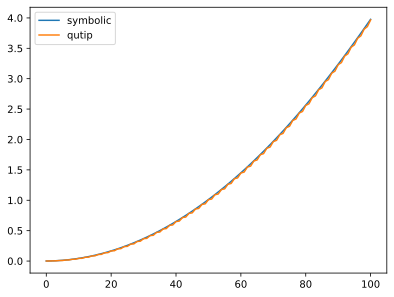

In [3]:
plt.plot(result.expect[-1],label='symbolic')
plt.plot(results_qutip.expect[-1],label='qutip')
plt.legend()

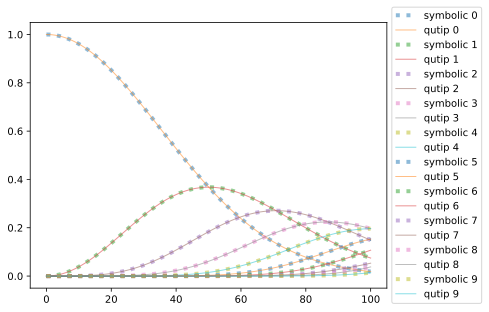

In [4]:
for ol in range(max_ol):
    plt.plot(result.expect[ol],label=f'symbolic {ol}',alpha=0.5,linewidth=4,linestyle=':')
    plt.plot(results_qutip.expect[ol],label=f'qutip {ol}',alpha=0.5,linewidth=1)
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))